In [1]:
import os
import joblib
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import mlflow.tensorflow
from dotenv import load_dotenv
import pandas as pd

# Charge les variables d'environnement et configure MLflow
load_dotenv()
tracking_uri = "https://mlflowp51-975919512217.us-central1.run.app"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("Text_Processing_Experiment")

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "f8bc1d91ca98.json"



c:\Users\leenc\Documents\openclassrooms\p5\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Charge les données du DataFrame depuis mlflow_artifacts
def load_dataframe():
    df = pd.read_csv('db/cleaned_data_sample.csv')

    return df

# Charge les objets du modèle depuis mlflow_artifacts
def load_model_objects():
    with open('mlflow_artifacts/vectorizer.pkl', 'rb') as f:
        vectorizer = joblib.load(f)
    with open('mlflow_artifacts/svd.pkl', 'rb') as f:
        svd = joblib.load(f)
    with open('mlflow_artifacts/top_tags.pkl', 'rb') as f:
        top_tags = joblib.load(f)
    with open('mlflow_artifacts/X_use_embeddings.pkl', 'rb') as f:
        X_use_np = joblib.load(f)
    with open('mlflow_artifacts/y.pkl', 'rb') as f:
        y = joblib.load(f)
    return vectorizer, svd, top_tags, X_use_np, y

# Chargement des données et des objets
df = load_dataframe()
vectorizer, svd, top_tags, X_use_np, y = load_model_objects()


In [3]:
print(df.head())
print(df.columns)
X = vectorizer.transform(df['Cleaned_Body'])


                                               Title  \
0       Remove duplicates, keeping most frequent row   
1  Basemap import error in PyCharm — KeyError: 'P...   
2  Spring Boot 3.x upgrade. Could not resolve org...   
3               Refactoring switch statement to enum   
4                   virtualenv to path on Windows 10   

                                       Cleaned_Title  \
0        Remove duplicates keeping most frequent row   
1      Basemap import error PyCharm KeyError PROJLIB   
2  Spring Boot upgrade Could not resolve orgsprin...   
3                  Refactoring switch statement enum   
4                            virtualenv path Windows   

                                                Body  \
0  <p>I would like to deduplicate my data, keepin...   
1  <p>I tried to use Basemap package to plot a ma...   
2  <p>I recently wanted to upgrade my kotlin proj...   
3  <p>I would like to clean my code and make it m...   
4  <p>I have installed virtualenv (if I type "

In [4]:
# Modèle BERT et le tokenizer de Hugging Face
def initialize_bert_model():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    return tokenizer, bert_model

# Transforme un texte en embeddings BERT
def transform_text_to_embedding(text, tokenizer, bert_model):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True, max_length=128)
    outputs = bert_model(inputs)
    embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()
    return embeddings

# Initialise le modèle BERT
tokenizer, bert_model = initialize_bert_model()

# Génére les embeddings pour tout le corpus
embeddings = np.vstack(df['Cleaned_Body'].apply(lambda x: transform_text_to_embedding(x, tokenizer, bert_model)).values)


c:\Users\leenc\Documents\openclassrooms\p5\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Pour n_clusters = 2, le score de silhouette moyen est : 0.11439096182584763
Pour n_clusters = 3, le score de silhouette moyen est : 0.10598776489496231
Pour n_clusters = 4, le score de silhouette moyen est : 0.06987746059894562
Pour n_clusters = 5, le score de silhouette moyen est : 0.04709065333008766
Pour n_clusters = 6, le score de silhouette moyen est : 0.042083628475666046
Pour n_clusters = 7, le score de silhouette moyen est : 0.03937775641679764
Pour n_clusters = 8, le score de silhouette moyen est : 0.029982155188918114
Pour n_clusters = 9, le score de silhouette moyen est : 0.03322090953588486
Pour n_clusters = 10, le score de silhouette moyen est : 0.02966366708278656


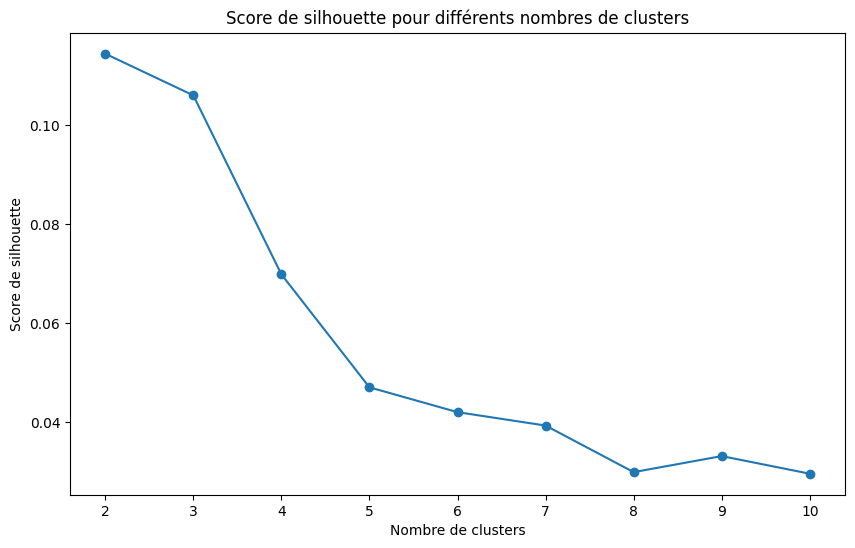

Le nombre optimal de clusters est : 2


In [5]:
# Evalue le nombre optimal de clusters avec le score de silhouette
def evaluate_kmeans_clustering(embeddings, range_n_clusters):
    silhouette_scores = []
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(embeddings)
        cluster_labels = kmeans.predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Pour n_clusters = {n_clusters}, le score de silhouette moyen est : {silhouette_avg}")
    return silhouette_scores

# Définit la plage de clusters et évaluer le modèle
range_n_clusters = range(2, 11)
silhouette_scores = evaluate_kmeans_clustering(embeddings, range_n_clusters)

# Trace les scores de silhouette pour différents nombres de clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette")
plt.title("Score de silhouette pour différents nombres de clusters")
plt.show()

# Nombre de clusters optimal
optimal_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Le nombre optimal de clusters est : {optimal_n_clusters}")






In [6]:
# Entraîne le modèle KMeans avec le nombre optimal de clusters
def train_kmeans_model(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)
    return kmeans

y_filtered = y[:len(X_use_np)]
assert len(y_filtered) == len(X_use_np), "Les tailles de y et des embeddings ne correspondent pas"

def suggest_tags(text, kmeans, tokenizer, bert_model, top_tags):
    embedding = transform_text_to_embedding(text, tokenizer, bert_model)
    cluster = kmeans.predict(embedding)
    cluster_indices = np.where(kmeans.labels_ == cluster)[0]
    
    print(f"Indices des points dans le même cluster: {cluster_indices}")
    
    # Filtre les indices pour éviter l'indexation hors limites
    cluster_indices = [idx for idx in cluster_indices if idx < len(y_filtered)]
    
    tag_counts = {}
    for idx in cluster_indices:
        tags = y_filtered[idx]
        for i, tag_active in enumerate(tags):
            if tag_active:  # Si le tag est actif (1)
                tag_name = top_tags[i]
                if tag_name in tag_counts:
                    tag_counts[tag_name] += 1
                else:
                    tag_counts[tag_name] = 1
    
    sorted_tags = sorted(tag_counts.items(), key=lambda item: item[1], reverse=True)
    suggested_tags = [tag for tag, count in sorted_tags[:10]]  # Limite : 10
    return suggested_tags


# Entraîne le modèle KMeans
kmeans = train_kmeans_model(embeddings, optimal_n_clusters)

# Teste avec une nouvelle question
new_question = "how to center a div?"
suggested_tags = suggest_tags(new_question, kmeans, tokenizer, bert_model, top_tags)
print(f"Suggested tags for '{new_question}': {suggested_tags}")


Indices des points dans le même cluster: [  0   3   4   5   7  10  11  12  13  18  19  20  21  22  23  24  25  26
  28  29  31  33  36  37  38  39  40  43  44  45  49  55  56  57  58  61
  62  65  67  68  70  71  76  78  79  80  81  82  83  86  88  89  91  94
  95  96  97 101 102 103 104 106 109 112 115 116 118 119 120 121 122 123
 126 127 128 129 131 132 136 137 138 141 142 145 146 147 153 154 156 163
 164 165 167 168 170 173 174 179 180 181 184 189 190 191 192 194 195 196
 199 200 202 205 207 210 211 213 216 219 220 222 223 226 230 232 234 235
 236 241 242 243 244 246 248 250 253 254 255 256 258 259 263 264 265 267
 269 272 274 277 278 280 285 286 288 289 290 291 295 299 300 301 305 306
 307 308 311 312 314 315 320 323 324 327 330 332 335 336 337 340 341 343
 344 347 348 354 358 360 361 364 366 370 372 375 376 377 378 379 381 384
 385 387 390 394 396 397 399 401 402 403 407 410 412 413 414 416 417 418
 423 424 425 427 428 430 431 432 434 435 436 437 438 439 441 446 447 451
 454 455 4

In [7]:
# Modèle LDA avec GridSearchCV pour trouver les hyperparamètres optimaux
search_params = {'n_components': [5, 10, 15, 20], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation(random_state=42)
model = GridSearchCV(lda, param_grid=search_params)
model.fit(X)

# Meilleur modèle LDA trouvé par GridSearchCV
best_lda_model = model.best_estimator_

# Journalisation du modèle LDA dans MLflow
with mlflow.start_run(run_name="LDA_Model_Training"):
    mlflow.log_param("n_topics", model.best_params_['n_components'])
    mlflow.sklearn.log_model(best_lda_model, "LDA_Model")

# Extraction des mots-clés pour chaque topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# Affichage des mots-clés pour chaque topic
n_top_words = 10
print_top_words(best_lda_model, vectorizer.get_feature_names_out(), n_top_words)


2024/10/11 11:26:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/11 11:26:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/11 11:26:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run LDA_Model_Training at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/cc67e729b2cf4220b72a21152feb5eaa.
2024/10/11 11:26:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


Topic #0:
public class return and true the new implementation private import
Topic #1:
the from const ltdiv and ltdivgt value return this npm
Topic #2:
the return int with for function array and this error
Topic #3:
the file quotquot error and from this run not line
Topic #4:
the and this that for but have with not can



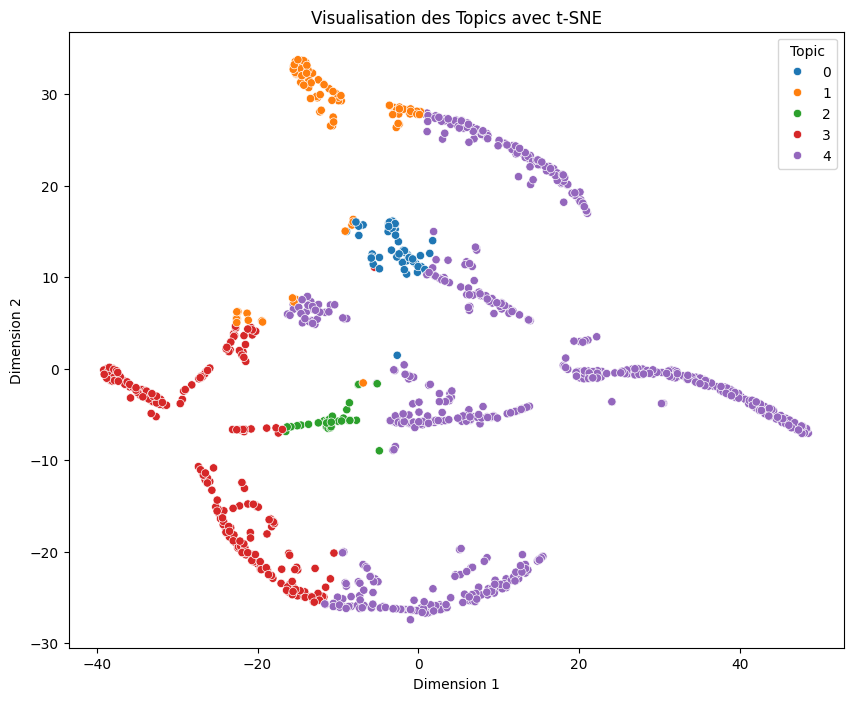

In [12]:
# Réduction de la dimensionnalité avec t-SNE pour visualiser en 2D
topic_distributions = best_lda_model.transform(X)
tsne = TSNE(n_components=2, random_state=42)
topic_distributions_2d = tsne.fit_transform(topic_distributions)

# Topics en 2D
plt.figure(figsize=(10, 8))
sns.scatterplot(x=topic_distributions_2d[:, 0], y=topic_distributions_2d[:, 1], hue=topic_distributions.argmax(axis=1), palette='tab10')
plt.title('Visualisation des Topics avec t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Topic')
plt.show()


In [13]:
import os

# Répertoire de sauvegarde des modèles dans mlflow_artifacts
model_save_directory = "mlflow_artifacts/"
os.makedirs(model_save_directory, exist_ok=True)

# Journalisation des modèles KMeans, LDA et BERT dans MLflow
with mlflow.start_run(run_name="KMeans_Clustering"):
    kmeans_model_path = os.path.join(model_save_directory, "KMeans_Model")
    mlflow.sklearn.log_model(kmeans, artifact_path=kmeans_model_path)
    print(f"KMeans model saved to: {kmeans_model_path}")

with mlflow.start_run(run_name="LDA_Model_Training"):
    lda_model_path = os.path.join(model_save_directory, "LDA_Model")
    mlflow.sklearn.log_model(best_lda_model, artifact_path=lda_model_path)
    print(f"LDA model saved to: {lda_model_path}")

with mlflow.start_run(run_name="BERT_Model_Training"):
    bert_model_path = os.path.join(model_save_directory, "BERT_Model")
    mlflow.tensorflow.log_model(bert_model, artifact_path=bert_model_path)
    print(f"BERT model saved to: {bert_model_path}")


2024/10/11 11:31:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/11 11:31:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run KMeans_Clustering at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/cabdf35f8aa94f04a2b381cfab85f1e9.
2024/10/11 11:31:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


KMeans model saved to: mlflow_artifacts/KMeans_Model


2024/10/11 11:31:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/11 11:31:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/11 11:31:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run LDA_Model_Training at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/9dcd24bc7b8c49c5932032c47928d36e.
2024/10/11 11:31:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


LDA model saved to: mlflow_artifacts/LDA_Model


2024/10/11 11:31:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\leenc\AppData\Local\Temp\tmpyqqzziwe\model\tf2model\assets


INFO:tensorflow:Assets written to: C:\Users\leenc\AppData\Local\Temp\tmpyqqzziwe\model\tf2model\assets
2024/10/11 11:32:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/11 11:33:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run BERT_Model_Training at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/5c7f8422f3cf4fc79c84dd8730780b1a.
2024/10/11 11:33:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


BERT model saved to: mlflow_artifacts/BERT_Model
